My SOM

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
import PIL
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Dropout, Dense, Softmax)
from tensorflow.keras.applications import mobilenet as _mobilenet
import random
import os
import numpy as np
from PIL import Image
import networkx as nx
from sklearn.neighbors import NearestNeighbors
from IPython.display import Image as iImage
from IPython.display import display
import math
import matplotlib.pyplot as plt

In [3]:
def load_image(img_file, target_size=(224,224)):
    X = np.zeros((1, *target_size, 3))
    X[0, ] = np.asarray(tf.keras.preprocessing.image.load_img(
        img_file,
        target_size=target_size)
    )
    X = tf.keras.applications.mobilenet.preprocess_input(X)
    return X

def ensure_folder_exists(folder):
    if not os.path.exists(folder):
        os.makedirs(folder)

In [4]:
def processImage(imagePath, model):
    im = load_image(imagePath)
    f = model.predict(im)[0]
    return f

In [5]:
model = tf.keras.applications.mobilenet.MobileNet(
# The 3 is the three dimensions of the input: r,g,b.
  input_shape=(224, 224, 3),
  include_top=False,
  pooling='avg'
)

17225924/17225924 [==============================] - 0s 0us/step


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
MosqueImages = os.listdir('/content/drive/MyDrive/2.21/Prophet_Mosque')
MosqueImages = MosqueImages[:400]

In [9]:
features = []
for m in MosqueImages:
    path = os.path.join('/content/drive/MyDrive/2.21/Prophet_Mosque', m)
    f = processImage(path, model)
    features.append(f)

1/1 [==============================] - 0s 64ms/step


In [10]:
featureImagePairs = []
for i in range(len(features)):
    featureImage = {}
    featureImage['image'] = MosqueImages[i]
    featureImage['feature'] = features[i]
    featureImagePairs.append(featureImage)

In [11]:
featureImagePairs[0]

{'image': '113.jpg',
 'feature': array([0.27321646, 0.44322303, 0.46511912, ..., 1.5896654 , 0.00885059,
        0.        ], dtype=float32)}

In [12]:
def normalise(train, p):
    min_d = np.min(train)
    max_d = np.max(train)
    normalised_p = (p-min_d)/(max_d - min_d)
    return normalised_p
def denormalise(train, p):
    min_d = np.min(train)
    max_d = np.max(train)
    denormalised_p = p * (max_d - min_d) + min_d
    return denormalised_p

In [13]:
import sklearn

def euclidean(a, b):
    return np.linalg.norm(a-b)

def u_matrix(lattice):
    """Builds a U-matrix on top of the trained lattice.

        Parameters
        ---
        lattice : list

            The SOM generated lattice

        Returns
        ---
        The lattice of the shape (R,C):

        R - number of rows; C - number of columns;
        """
    X, Y, Z = lattice.shape
    u_values = np.empty((X,Y), dtype=np.float64)

    for y in range(Y):
        for x in range(X):
            current = lattice[x,y]
            dist = 0
            num_neigh = 0
            # left
            if x-1 >= 0:
                #middle
                vec = lattice[x-1,y]
                dist += euclidean(current, vec)
                num_neigh += 1
                if y - 1 >= 0:
                    #sup
                    vec = lattice[x-1, y-1]
                    dist += euclidean(current, vec)
                    num_neigh += 1
                if y + 1 < Y:
                    # down
                    vec = lattice[x-1,y+1]
                    dist += euclidean(current, vec)
                    num_neigh += 1
            # middle
            if y - 1 >= 0:
                # up
                vec = lattice[x,y-1]
                dist += euclidean(current, vec)
                num_neigh += 1
            # down
            if y + 1 < Y:
                vec = lattice[x,y+1]
                dist += euclidean(current, vec)
                num_neigh += 1
            # right
            if x + 1 < X:
                # middle
                vec = lattice[x+1,y]
                dist += euclidean(current, vec)
                num_neigh += 1
                if y - 1 >= 0:
                    #up
                    vec = lattice[x+1,y-1]
                    dist += euclidean(current, vec)
                    num_neigh += 1
                if y + 1 < lattice.shape[1]:
                    # down
                    vec = lattice[x+1,y+1]
                    dist += euclidean(current, vec)
                    num_neigh += 1
            u_values[x,y] = dist / num_neigh
    u_values = (u_values - 1) * -1
    return u_values

In [14]:
# Return the (g,h) index of the BMU in the grid
def find_BMU(SOM,x):
    distSq = (np.square(SOM - x)).sum(axis=2)
    return np.unravel_index(np.argmin(distSq, axis=None), distSq.shape)

# Update the weights of the SOM cells when given a single training example
# and the model parameters along with BMU coordinates as a tuple
def update_weights(SOM, train_ex, learn_rate, radius_sq,
                   BMU_coord, step=3):
    g, h = BMU_coord
    #if radius is close to zero then only BMU is changed
    if radius_sq < 1e-3:
        SOM[g,h,:] += learn_rate * (train_ex - SOM[g,h,:])
        return SOM
    # Change all cells in a small neighborhood of BMU
    for i in range(max(0, g-step), min(SOM.shape[0], g+step)):
        for j in range(max(0, h-step), min(SOM.shape[1], h+step)):
            dist_sq = np.square(i - g) + np.square(j - h)
            dist_func = np.exp(-dist_sq / 2 / radius_sq)
            SOM[i,j,:] += learn_rate * dist_func * (train_ex - SOM[i,j,:])
    return SOM

# Main routine for training an SOM. It requires an initialized SOM grid
# or a partially trained grid as parameter
def train_SOM(SOM, train_data, learn_rate = .1, radius_sq = 1,
             lr_decay = .1, radius_decay = .1, epochs = 10):
    learn_rate_0 = learn_rate
    radius_0 = radius_sq
    for epoch in np.arange(0, epochs):
        rand.shuffle(train_data)
        for train_ex in train_data:
            g, h = find_BMU(SOM, train_ex)
            SOM = update_weights(SOM, train_ex,
                                 learn_rate, radius_sq, (g,h))
        # Update learning rate and radius
        learn_rate = learn_rate_0 * np.exp(-epoch * lr_decay)
        radius_sq = radius_0 * np.exp(-epoch * radius_decay)
    return SOM
import scipy
def calculateQE(SOM,data):
    sumSqDist = 0
    for d in data:
        g,h = find_BMU(SOM, d)
        v1 = SOM[g,h]
        v2 = d
        sumSqDist += scipy.spatial.distance.cdist([v1],[v2],'sqeuclidean')[0][0]
    QE = sumSqDist/len(data)
    return QE
# Return the (g,h) index of the BMU in the grid
def find_BMU_2(SOM,x):
    distSq = (np.square(SOM - x)).sum(axis=2)
    return np.unravel_index(np.argpartition(distSq, 2, axis=None)[2], distSq.shape)
def calculateTE(SOM,data):
    failed = 0
    for d in data:
        g1,h1 = find_BMU(SOM,d)
        g2,h2 = find_BMU_2(SOM,d)
        dist = scipy.spatial.distance.cityblock([g1,h1], [g2,h2])
        if dist>1:
            failed+=1
    return failed/len(data)
def activate(train_data, SOM, p):
    normalP = normalise(train_data, p)
    activatedSOM = np.array([[euclidean(normalP, c) for c in r] for r in SOM])
    normalisedActivatedSOM = normalise(activatedSOM, activatedSOM)
    activatedSOM = (normalisedActivatedSOM -1)*(-1)
    return activatedSOM

In [15]:
# Dimensions of the SOM grid
m = 10
n = 10
# Number of training examples
n_x = 400
rand = np.random.RandomState(0)
# Initialize the training data
train_data = features

# Normalised Training Data
n_train_data = normalise(train_data, train_data)

# Initialize the SOM randomly
SOM = rand.uniform(0, 1, (m, n, len(train_data[0])))

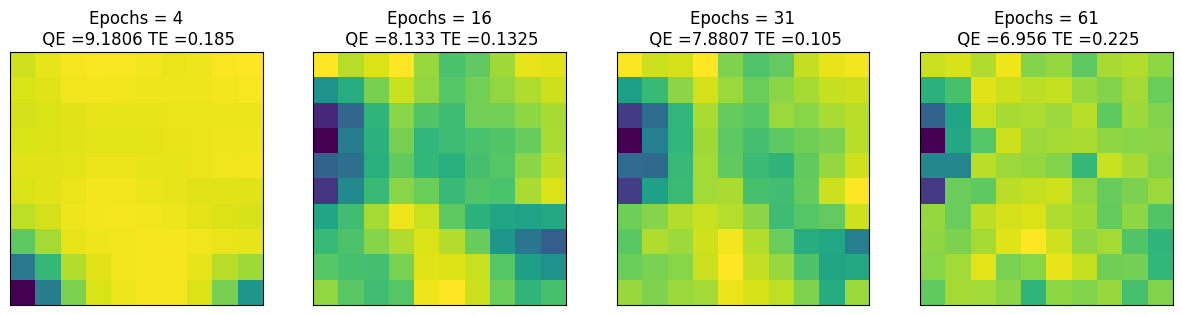

In [16]:
fig, ax = plt.subplots(
    nrows=1, ncols=4, figsize=(15, 3.5),
    subplot_kw=dict(xticks=[], yticks=[]))
total_epochs = 0
SOMS = []
for epochs, i in zip([4, 12, 15, 30], range(0,4)):
    total_epochs += epochs
    SOM = train_SOM(SOM, n_train_data, learn_rate = .1, radius_sq = 2, epochs = epochs)
    SOMS.append(SOM)
    QE = round(calculateQE(SOM, n_train_data), 4)
    TE = round(calculateTE(SOM, n_train_data), 4)

    ax[i].imshow(u_matrix(SOM))
    ax[i].title.set_text('Epochs = ' + str(total_epochs) + '\n QE =' + str(QE) + ' TE =' + str(TE))

In [17]:
SOM = SOMS[1]

In [18]:
find_BMU(SOM, normalise(train_data,featureImagePairs[0]['feature']))

(9, 4)

In [19]:
SOMimages = []
for i in range(len(SOM)):
    row = []
    for j in range(len(SOM[0])):
        row.append([])
    SOMimages.append(row)

In [20]:
for fi in featureImagePairs:
    g,h = find_BMU(SOM, normalise(train_data, fi['feature']))
    SOMimages[g][h].append(fi)

In [23]:
SOMimages[0][0]

[{'image': '115.jpg',
  'feature': array([0.38024953, 1.3699468 , 1.7487096 , ..., 0.6291712 , 0.06213546,
         0.        ], dtype=float32)},
 {'image': '103.jpg',
  'feature': array([0.17131463, 0.48133898, 1.9946406 , ..., 0.22874677, 0.        ,
         0.        ], dtype=float32)},
 {'image': '118.jpg',
  'feature': array([0.17602418, 1.3248774 , 1.653807  , ..., 0.03904637, 0.        ,
         0.0044343 ], dtype=float32)},
 {'image': '133.jpg',
  'feature': array([0.8251295 , 0.53015435, 3.0094216 , ..., 0.27341145, 0.        ,
         0.        ], dtype=float32)},
 {'image': '155.jpg',
  'feature': array([0.4176234 , 1.5216812 , 1.8637054 , ..., 0.00574994, 0.3906546 ,
         0.        ], dtype=float32)},
 {'image': '144.jpg',
  'feature': array([0.0771115 , 0.9689524 , 0.63207805, ..., 0.27261904, 0.10765692,
         0.02592304], dtype=float32)},
 {'image': '171.jpg',
  'feature': array([1.0796884 , 1.2515298 , 2.1936932 , ..., 0.36510062, 0.3916191 ,
         0.222035

In [24]:
[[len(c) for c in r] for r in SOMimages]

[[11, 3, 9, 6, 7, 6, 6, 9, 6, 11],
 [4, 4, 2, 5, 4, 1, 3, 4, 3, 6],
 [3, 2, 0, 6, 4, 3, 6, 3, 3, 3],
 [7, 2, 5, 2, 2, 1, 4, 3, 4, 6],
 [3, 5, 0, 5, 6, 2, 9, 0, 2, 5],
 [5, 1, 5, 3, 2, 0, 2, 3, 6, 6],
 [1, 4, 4, 2, 5, 5, 2, 2, 3, 5],
 [8, 5, 3, 3, 3, 3, 5, 1, 2, 5],
 [2, 1, 0, 7, 4, 0, 5, 2, 1, 3],
 [7, 6, 6, 4, 4, 3, 7, 2, 5, 11]]

In [25]:
from scipy import spatial

imageGrid = []
for g in range(len(SOMimages)):
    row = SOMimages[g]
    for h in range(len(row)):
        cell = row[h]
        if len(cell) > 0:
            imageGrid.append(cell[0]['image'])
        else:
            imageGrid.append('white.jpg')

In [26]:
def img_reshape(img):
    img = Image.open('/content/drive/MyDrive/2.21/Prophet_Mosque/'+img).convert('RGB')
    img = img.resize((100,100))
    img = np.asarray(img)
    return img

In [27]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np

img_arr = []
for image in imageGrid:
    img_arr.append(img_reshape(image))

fig = plt.figure(figsize=(20., 20.))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(10, 10),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes
                 )

for ax, im in zip(grid, img_arr):
    ax.imshow(im)
    ax.axis('off')
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [30]:
featureImagePairs[0]

{'image': '113.jpg',
 'feature': array([0.27321646, 0.44322303, 0.46511912, ..., 1.5896654 , 0.00885059,
        0.        ], dtype=float32)}

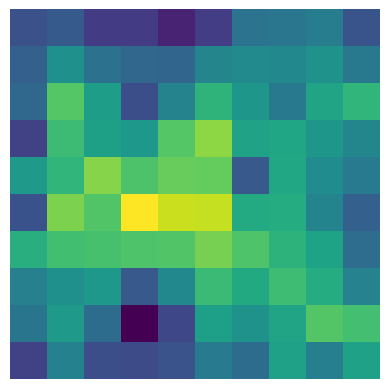

In [31]:
activatedSOM = activate(train_data, SOM, normalise(train_data,featureImagePairs[0]['feature']))
fig = plt.figure()
plt.imshow(activatedSOM)
plt.axis('off')
plt.show()

Pickle

In [32]:
import pickle

def save_som_model(model, filename):
    if not filename.endswith('.obj'):
        filename += '.obj'  # Ensure filename has .obj extension
    with open(filename, 'wb') as f:
        pickle.dump(model, f)
    print(f"Model saved as '{filename}'.")

In [33]:
save_som_model(SOM, 'trainedSOM')

Model saved as 'trainedSOM.obj'.


Load Saved SOM

In [34]:
def load_som_model(filename):
    with open(filename, 'rb') as f:
        SOM = pickle.load(f)
    print(f"Model loaded from '{filename}'.")
    return SOM

In [35]:
load_som_model('trainedSOM.obj')

Model loaded from 'trainedSOM.obj'.


array([[[0.06338214, 0.19369838, 0.30103076, ..., 0.06635689,
         0.0288722 , 0.0055465 ],
        [0.07598967, 0.14665551, 0.28565576, ..., 0.13099012,
         0.01006176, 0.01162675],
        [0.05323278, 0.13731689, 0.0986904 , ..., 0.15366164,
         0.00048724, 0.01902471],
        ...,
        [0.07678419, 0.1073072 , 0.00748766, ..., 0.22466677,
         0.00355657, 0.03893274],
        [0.07276192, 0.18449525, 0.02307579, ..., 0.24016423,
         0.02186276, 0.08904576],
        [0.0847839 , 0.18927572, 0.04351354, ..., 0.2039811 ,
         0.02104135, 0.0986857 ]],

       [[0.0346408 , 0.11488971, 0.32153668, ..., 0.05892529,
         0.07687779, 0.02690283],
        [0.05214043, 0.11324304, 0.20576801, ..., 0.20621368,
         0.01927988, 0.02505129],
        [0.05976114, 0.16267048, 0.12107928, ..., 0.1615588 ,
         0.00448004, 0.01385886],
        ...,
        [0.0647385 , 0.08231745, 0.01174347, ..., 0.19374491,
         0.00420759, 0.0389999 ],
        [0.0

Closest

In [36]:
SOMimages[0][0][1]

{'image': '103.jpg',
 'feature': array([0.17131463, 0.48133898, 1.9946406 , ..., 0.22874677, 0.        ,
        0.        ], dtype=float32)}

In [38]:
SOM[0][0]

array([0.06338214, 0.19369838, 0.30103076, ..., 0.06635689, 0.0288722 ,
       0.0055465 ])

In [39]:
def distance_between(a, b):
    a = np.asarray(a, dtype=np.float64)
    b = np.asarray(b, dtype=np.float64)
    return np.linalg.norm(a - b)

In [40]:
def find_closest_image_index(distance):
    closest_index = 0
    distance_closest = distance[0]

    for index in range(1, len(distance)):
        if distance[index] < distance_closest:
            distance_closest = distance[index]
            closest_index = index

    return closest_index

In [41]:
def get_closest_image(a,b):
  cell = SOM[a][b]
  distance = [distance_between(cell, i['feature']) for i in SOMimages[a][b]]
  closest_image_index=find_closest_image_index(distance)
  return closest_image_index

In [42]:
from scipy import spatial

imageGrid = []
for g in range(len(SOMimages)):
    row = SOMimages[g]
    for h in range(len(row)):
        cell = row[h]
        if len(cell) > 0:
            closest_image_index=get_closest_image(g,h)
            imageGrid.append(cell[closest_image_index]['image'])
        else:
            imageGrid.append('white.jpg')

In [43]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np

img_arr = []
for image in imageGrid:
    img_arr.append(img_reshape(image))

fig = plt.figure(figsize=(20., 20.))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(10, 10),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes
                 )

for ax, im in zip(grid, img_arr):
    ax.imshow(im)
    ax.axis('off')
plt.show()

Output hidden; open in https://colab.research.google.com to view.

Function

In [44]:
def get_closest_image_inall(a,b):
  cell = SOM[a][b]
  distance = [distance_between(cell, normalise(train_data,i['feature'])) for i in featureImagePairs]
  closest_image_index=find_closest_image_index(distance)
  return closest_image_index

In [45]:
from scipy import spatial

imageGrid = []
for g in range(len(SOMimages)):
    row = SOMimages[g]
    for h in range(len(row)):
        cell = row[h]
        if len(cell) > 0:
            closest_image_index=get_closest_image_inall(g,h)
            imageGrid.append(featureImagePairs[closest_image_index]['image'])
        else:
            imageGrid.append('white.jpg')

In [46]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np

img_arr = []
for image in imageGrid:
    img_arr.append(img_reshape(image))

fig = plt.figure(figsize=(20., 20.))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(10, 10),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes
                 )

for ax, im in zip(grid, img_arr):
    ax.imshow(im)
    ax.axis('off')
plt.show()

Output hidden; open in https://colab.research.google.com to view.

UMatrix Visualize

In [47]:
from matplotlib.colors import LinearSegmentedColormap

In [48]:
def visualize_umatrix(u_matrix_values, cmap_colors='BuPu'):
    if isinstance(cmap_colors, str):
        cmap = plt.get_cmap(cmap_colors)
    else:
        cmap = LinearSegmentedColormap.from_list('custom_cmap', cmap_colors)
    plt.figure(figsize=(10, 10))
    im = plt.imshow(u_matrix_values, cmap=cmap, aspect='auto')
    plt.title('U-Matrix')
    plt.colorbar(im, shrink=0.95, label='Distance')
    plt.show()

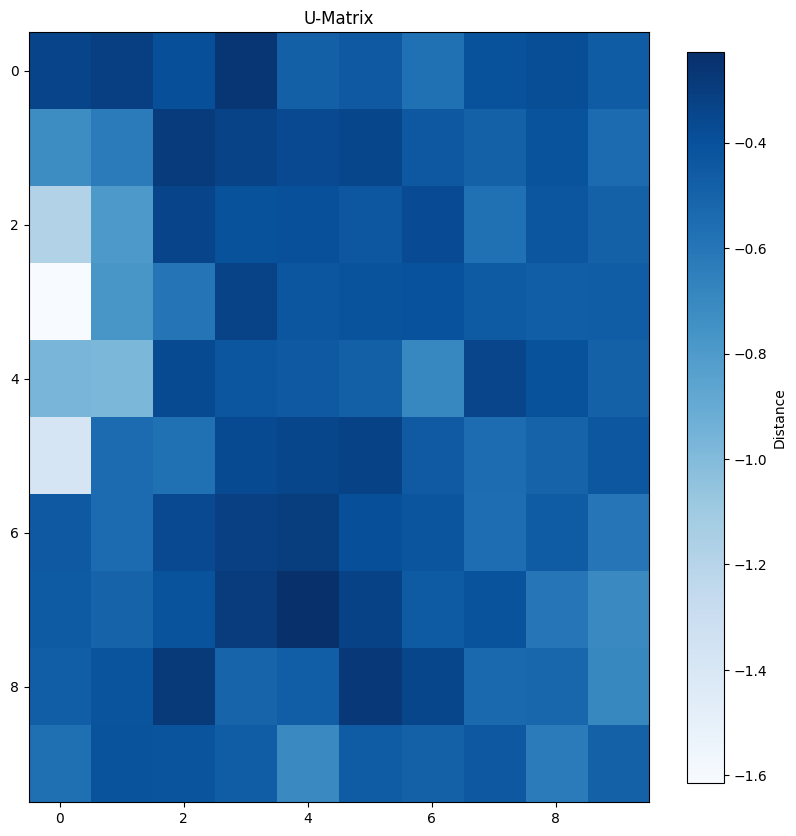

In [50]:
u_matrix_values = u_matrix(SOM)
visualize_umatrix(u_matrix_values, cmap_colors='Blues')